In [1]:
import torch
from torch import nn
from torch import autograd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

In [2]:
SEQ_LEN = 61
BATCH_SIZE = 32
EPOCHS = 300
DIM = 256
DIM_embedding = 128
k = 5
charmap = {'A': 1, 'T': 2, 'C': 3, 'G': 4}
Train_PATH = '【数据集-文献】re-data578.csv'#训练集和验证集

In [3]:
#模型结构 from try6-copy4
class Prediction(nn.Module):
    """
    个人构造的预测器模型,输入数据为encode后的序列
    """
    def __init__(self):
        super(Prediction, self).__init__()
        self.Embedding = torch.nn.Embedding(num_embeddings=5,embedding_dim=DIM_embedding)
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv1 = nn.Conv1d(in_channels = DIM_embedding, out_channels = DIM, kernel_size = 5,padding = 2)
        self.BatchNorm1d = nn.BatchNorm1d(DIM)
        self.relu1 = nn.ReLU()
        self.MaxPool1d = nn.MaxPool1d(kernel_size=2)
       
        self.conv2 = nn.Conv1d(in_channels = DIM, out_channels = DIM, kernel_size = 5,padding = 2)
        self.BatchNorm1d = nn.BatchNorm1d(DIM)
        self.relu1 = nn.ReLU()
        self.MaxPool1d = nn.MaxPool1d(kernel_size=3,stride=2)
        
        self.dropout = nn.Dropout(p=0.2)
        self.LSTM = nn.LSTM(input_size=DIM,hidden_size=DIM,num_layers=1)
        self.linear = nn.Linear(60 * DIM, 1)
        
    def forward(self,x):
        x = self.Embedding(x) #(batch_size, seq_len, embedding_dim)
        x = self.dropout(x)  #(batch_size, seq_len, embedding_dim)
        
        x = x.permute(0, 2, 1)#(batch_size, embedding_dim, seq_len)
        x = self.conv1(x)   #(batch_size, dim, seq_len)
        x = self.dropout(x)
        x = self.relu1(x)#(batch_size, dim, seq_len)
        x = self.MaxPool1d(x)#(batch_size, dim, 30)
        #x = self.BatchNorm1d(x)#(batch_size, dim, 30)
        x = x.permute(0, 2, 1)#(batch_size,30,dim,)
        x1,(hn,cn) = self.LSTM(x)#(batch_size, 30, dim)
        
        x = x.permute(0, 2, 1)#(batch_size, dim, 30)
        x = self.conv2(x)   #(batch_size, dim, 30)
        x = self.dropout(x)
        x = self.relu1(x)#(batch_size, dim, 30)
        x = self.BatchNorm1d(x)#(batch_size, dim, 30)
        x = x.permute(0, 2, 1)#(batch_size,30,dim,)
        x2,(hn,cn) = self.LSTM(x)#(batch_size, 30, dim)
        
        x = torch.cat((x1,x2),1)
        x = self.dropout(x)
        x = torch.reshape(x, (-1, 60 * DIM)) #(batch_size, seq_len * dim)
        x = self.linear(x) #(batch_size, 1)
        x = x.squeeze(-1)
        return x

In [4]:
#定义数据集Dataset
class TraindataSet(Dataset):
    def __init__(self,train_features,train_labels):
        self.x_data = train_features
        self.y_data = train_labels
        self.len = len(train_labels)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

def encoding(data):
    seq = []
    i = 0
    while i < len(data):
        tmp = []
        for item in data[i]:
            if item == 't' or item == 'T':
                tmp.append(charmap['T'])
            elif item == 'c' or item == 'C':
                tmp.append(charmap['C'])
            elif item == 'g' or item == 'G':
                tmp.append(charmap['G'])
            elif item == 'a' or item == 'A':
                tmp.append(charmap['A'])
            else:
                tmp.append(0)
        seq.append(tmp)
        i = i+1
    output = torch.from_numpy(np.array(seq))
    #output = output.tolist()
    return output.to(device)

In [5]:
# K折划分
def get_k_fold_data(k, i, X, y): 
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  #slice(start,end,step)切片函数
        ## idx 为每组 valid
        X_part = X[idx,:]
        y_part = y[idx]
        if j == i: ###第i折作valid
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0) #dim=0增加行数，竖着连接
            y_train = torch.cat((y_train, y_part), dim=0)
    #print(X_train.size(),X_valid.size())
    return X_train, y_train, X_valid,y_valid

def k_fold(k,X_data,y_data, num_epochs=EPOCHS,learning_rate=0.001, weight_decay=0.1, batch_size=BATCH_SIZE):    
    train_loss_sum, valid_loss_sum = 0, 0
    train_MAE ,valid_MAE, train_reg_r2_sum, valid_reg_r2_sum,train_pccs_sum,valid_pccs_sum = 0, 0, 0, 0, 0, 0
    
    for i in range(1):
        X_train, y_train, X_valid,y_valid = get_k_fold_data(k, i, X_data, y_data) # 获取k折交叉验证的训练和验证数据
        net = Prediction().to(device)  ### 实例化模型
        train_ls, valid_ls = train(net, X_train, y_train, X_valid,y_valid, num_epochs, learning_rate, batch_size)
        print('*'*25,'第',i+1,'折','*'*25)
        print('train:{}, valid:{}'.format(len(X_train), len(X_valid)))
        print('train_loss:%.6f'%train_ls[0],'train_MAE:%.4f'%train_ls[1],'train_pccs:%.4f'%train_ls[3],'train_reg_r2:%.4f\n'%train_ls[2],
              'valid loss:%.6f'%valid_ls[0],'valid_MAE:%.4f'%valid_ls[1],'test_pccs:%.4f'%valid_ls[3],'valid_reg_r2:%.4f'%valid_ls[2])
        train_loss_sum += train_ls[0]
        valid_loss_sum += valid_ls[0]
        train_MAE += train_ls[1]
        valid_MAE += valid_ls[1]
        train_reg_r2_sum += train_ls[2]
        valid_reg_r2_sum += valid_ls[2]
        train_pccs_sum += train_ls[3]
        valid_pccs_sum += valid_ls[3]
        
    print('#'*25,'最终k折交叉验证结果','#'*25) 
    print('train_loss_sum:%.4f'%(train_loss_sum/k),'train_MAE:%.4f'%(train_MAE/k),'train_pccs:%.4f'%(train_pccs_sum/k),'train_reg_r2_sum:%.4f\n'%(train_reg_r2_sum/k),
          'valid_loss_sum:%.4f'%(valid_loss_sum/k),'valid_MAE:%.4f'%(valid_MAE/k),'test_pccs:%.4f'%(valid_pccs_sum/k),'valid_reg_r2_sum:%.4f\n'%(valid_reg_r2_sum/k))
    return net

In [6]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, batch_size):
    train_ls, test_ls = [], [] ##存储train_loss,test_loss
    dataset = TraindataSet(train_features, train_labels) 
    train_iter = DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = optim.Adam(params=net.parameters(), lr= learning_rate, betas=(0.5, 0.9))
    loss_func = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:  ###分批训练 
            output  = net(X)
            loss = loss_func(output,y)
            net.zero_grad()
            loss.backward()
            optimizer.step()
        tr_ls, tr_MAE, tr_reg_r2,tr_pccs,tr_result = log_rmse(0, net, train_features, train_labels)
        train_ls.append(tr_ls)
        te_ls, te_MAE, te_reg_r2,te_pccs,te_result = log_rmse(1, net, test_features, test_labels)
        test_ls.append(te_ls)

    #画图
    fig, axes = plt.subplots(1, 3, figsize=(12,3))
    x = np.array(range(num_epochs))
    axes[0].plot(x, train_ls, label = "loss_train", linewidth=0.25)
    axes[0].plot(x, test_ls, label = "loss_test", linewidth=0.25)
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")
    axes[0].legend(loc="best")
    
    axes[1].scatter(train_labels.cpu(), tr_result)
    axes[1].set_title("train")
    axes[1].set_xlabel('True value')
    axes[1].set_ylabel('Predict value')
    
    axes[2].scatter(test_labels.cpu(), te_result)
    axes[2].set_title("test")
    axes[2].set_xlabel('True value')
    axes[2].set_ylabel('Predict value')
    plt.show()
    return (tr_ls, tr_MAE, tr_reg_r2,tr_pccs), (te_ls, te_MAE, te_reg_r2,te_pccs)
 
def log_rmse(flag,net,x,y):
    net.eval()
    output = net(x)
    loss_func = torch.nn.MSELoss()
    loss = loss_func(output,y)
    result = output.cpu().detach().numpy()
    #r2 = r2_score(y.cpu(),result)
    MAE=mean_absolute_error(y.cpu(),result)
    
    #进行线性回归并计算r2
    regression_model = linear_model.LinearRegression()
    regression_model.fit(y.cpu().reshape(-1, 1), result.reshape(-1, 1))
    regression_r2 = regression_model.score(y.cpu().reshape(-1, 1), result.reshape(-1, 1))
    
    pccs,p = pearsonr(y.cpu(),result)
    #pccs = np.corrcoef(y.cpu(),result).reshape(-1, 1)

    net.train()
    return loss.data.item(), MAE, regression_r2, pccs, result

current device is:cuda


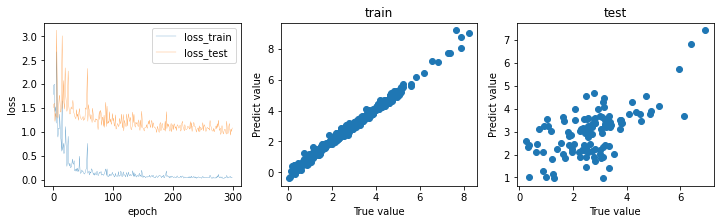

************************* 第 1 折 *************************
train:460, valid:115
train_loss:0.038242 train_MAE:0.1398 train_pccs:0.9948 train_reg_r2:0.9897
 valid loss:1.081002 valid_MAE:0.8045 test_pccs:0.6266 valid_reg_r2:0.3927
######################### 最终k折交叉验证结果 #########################
train_loss_sum:0.0076 train_MAE:0.0280 train_pccs:0.1990 train_reg_r2_sum:0.1979
 valid_loss_sum:0.2162 valid_MAE:0.1609 test_pccs:0.1253 valid_reg_r2_sum:0.0785



In [7]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('current device is:{}'.format(device))
    #P_net = Prediction().to(device)
    
    #数据读取，构造训练集
    dataset = pd.read_csv(Train_PATH,header=None)
    dataset = dataset.iloc[:,:4]
    X_data = dataset.iloc[:,1]
    Y_data = dataset.iloc[:,3]
    
    X_data = encoding(X_data)
    X_data = X_data.cpu().detach()
    X_data = torch.Tensor(X_data.float())
    X_data = X_data.int().to(device)
    Y_data = torch.Tensor(Y_data).to(device)
    index = [i for i in range(len(X_data))]
    np.random.shuffle(index)
    X_data = X_data[index]
    Y_data = Y_data[index]
    
    net = k_fold(k=5,X_data=X_data,y_data=Y_data)
    torch.save(net, 'predictor.pth')

In [8]:
seq = []
with open('nc1.txt') as f:
    for line in f:
        seq.append(line[:-1])

In [9]:
X_data = seq
X_data = encoding(X_data)
X_data = X_data.cpu().detach()
X_data = torch.Tensor(X_data.float())
X_data = X_data.int().to(device)

net.eval()
output = net(X_data)